# MNIST Hand-written digit classification

### 2019/3/22 성남-KAIST 인공지능 집중교육과정

***Tip> shotcuts for Jupyter Notebook***
* Shift + Enter : run cell and select below

***Library***
* Numpy: Fundamenta package for scientific computing with Python
* Tensorflow: An open source machine learning library for research and production
* Matplotlib: Python 2D plottin glibrary

In [1]:
from __future__ import print_function
from collections import namedtuple
from functools import partial

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.training import moving_averages

tf.logging.set_verbosity(tf.logging.ERROR)

## 1. Prepare the data
### <a href=http://yann.lecun.com/exdb/mnist/>MNIST dataset</a>
The MNIST has a training set of 55,000 examples, a validation set of 5,000 examples and a test set of 10,000 examples.

In [2]:
mnist = input_data.read_data_sets('./data/', one_hot=True)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


Load the training dataset

In [3]:
train_images = mnist.train.images
train_labels = mnist.train.labels
train_images = train_images.reshape([-1, 28, 28, 1])

Load the validation sets

In [4]:
val_images = mnist.validation.images
val_labels = mnist.validation.labels
val_images = val_images.reshape([-1, 28, 28, 1])

Plot the 1st hand-written digit and its one-hot label


One-hot labels for this image:
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


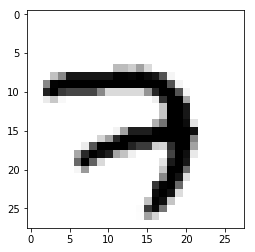

In [5]:
plt.imshow(train_images[0,:,:,0], cmap='Greys')
print("\nOne-hot labels for this image:")
print(train_labels[0])

## 2. Build a graph

### Set hyperparameters
- ***log_dir*** : Directory name to save models
- ***n_epochs*** : Maximun training epoch
- ***n_outputs*** : The number of classes for labels
- ***init_lr*** : Learning rate for gradient descent
- ***l2_lambda*** : regularization parameter
- ***batch_size*** : The number of images to update paramerters once

In [6]:
log_dir = 'logs/'
n_epochs = 20
n_outputs = 10
init_lr = 0.01
batch_size = 100
l2_lambda = 0.0001

### Placeholder for learning rate, input images and labels

In [7]:
lrn_rate = tf.placeholder(tf.float32, shape=(), name='lrn_rate')
images = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name='images')
labels = tf.placeholder(tf.int32, shape=(None), name='labels')

In [8]:
def DNN(images):
    w_init = tf.variance_scaling_initializer()
    b_init = tf.constant_initializer(0.)
    
    ## 1st hidden layer
    w1 = tf.get_variable('weight1', shape=[28*28, 200], initializer=w_init)     # weight for 1st hidden layer which have 200 units
    b1 = tf.get_variable('biases1', shape=[200], initializer=b_init)            # bias for 1st hidden layer which have 200 units
    h  = tf.matmul(images, w1) + b1                                             # matrix multiplication
    h  = tf.layers.batch_normalization(h)                                       # batch normalization
    h  = tf.nn.relu(h)                                                          # relu activation

    ## 2nd hidden layer
    w2 = tf.get_variable('weight2', shape=[200, 100], initializer=w_init)       # weight for 2nd hidden layer which have 100 units
    b2 = tf.get_variable('biases2', shape=[100], initializer=b_init)             # bias for 2nd hidden layer which have 100 units
    h  = tf.matmul(h, w2) + b2                                                  # matrix multiplication
    h  = tf.layers.batch_normalization(h)                                       # batch_normalization
    h  = tf.nn.relu(h)                                                          # relu activation
    
    return h

### Build a model

In [9]:
global_step = tf.Variable(0, trainable=False)

## Reshape
inputs = tf.reshape(images, [-1, 28*28])

with tf.variable_scope('embed') as scope:
    feats = DNN(inputs)

## Logits
logits = tf.layers.dense(feats, n_outputs, kernel_initializer=tf.uniform_unit_scaling_initializer(factor=2.0), 
                                               kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_lambda))

## Evaluation
correct = tf.nn.in_top_k(logits, labels, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

## SOFTMAX
preds = tf.nn.softmax(logits)

## Cost function
cent = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
loss = tf.reduce_mean(cent, name='cent')

### L2 regularization

In [10]:
all_var = [var for var in tf.trainable_variables() ]
l2_losses = []
for var in all_var:
    if var.op.name.find('weight') == 0:
        l2_losses.append(tf.nn.l2_loss(var))

reg_losses = loss + l2_lambda * tf.reduce_sum(l2_losses)

### Momentum optimizer

In [11]:
optimizer = tf.train.MomentumOptimizer(init_lr, 0.9, use_nesterov=True)                  # Momentum optimizer
train_op = optimizer.minimize(reg_losses)

# 3. Train a model

### Create a session and initialize parameters
Tensorflow operations must be executed in the session.

In [12]:
## MAKE SESSION
sess = tf.Session()

## INITIALIZE SESSION
sess.run(tf.global_variables_initializer())

### Updates parameters with back-propagation

In [13]:
start_time = time.time()

for epoch in range(n_epochs+1):
    for iteration in range(mnist.train.num_examples // batch_size):
        
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        X_batch = X_batch.reshape([-1, 28, 28, 1])
        (_, cost, prediction) = sess.run([train_op, loss, preds], 
                                                    feed_dict={images: X_batch, labels: y_batch})
        duration = time.time() - start_time
        sec_per_batch = float(duration)
    
    ## Training accuracy every one epoch
    acc_train = accuracy.eval(session=sess, feed_dict={images: X_batch, labels: np.argmax(y_batch, axis=1)})
    if epoch % 1 == 0:
        print('  [*] TRAINING Iteration %d, Loss: %.4f, Acc: %.4f (duration: %.3fs)'
                             % (epoch, cost, acc_train, sec_per_batch))

    ## Validation accuracy every 5 epochs
    if epoch % 5 == 0:
        acc_val = accuracy.eval(session=sess, feed_dict={images: val_images, labels: np.argmax(val_labels, axis=1)})
        print('  [*] VALIDATION ACC: %.3f' % acc_val)

print('Optimization done.')

  [*] TRAINING Iteration 0, Loss: 0.2236, Acc: 0.9500 (duration: 1.007s)
  [*] VALIDATION ACC: 0.945
  [*] TRAINING Iteration 1, Loss: 0.1966, Acc: 0.9200 (duration: 1.991s)
  [*] TRAINING Iteration 2, Loss: 0.1192, Acc: 0.9700 (duration: 2.944s)
  [*] TRAINING Iteration 3, Loss: 0.0503, Acc: 0.9900 (duration: 3.896s)
  [*] TRAINING Iteration 4, Loss: 0.0687, Acc: 0.9800 (duration: 4.852s)
  [*] TRAINING Iteration 5, Loss: 0.0296, Acc: 1.0000 (duration: 5.802s)
  [*] VALIDATION ACC: 0.978
  [*] TRAINING Iteration 6, Loss: 0.0177, Acc: 1.0000 (duration: 6.791s)
  [*] TRAINING Iteration 7, Loss: 0.0500, Acc: 0.9900 (duration: 7.732s)
  [*] TRAINING Iteration 8, Loss: 0.0310, Acc: 1.0000 (duration: 8.672s)
  [*] TRAINING Iteration 9, Loss: 0.0103, Acc: 1.0000 (duration: 9.625s)
  [*] TRAINING Iteration 10, Loss: 0.0461, Acc: 0.9900 (duration: 10.572s)
  [*] VALIDATION ACC: 0.982
  [*] TRAINING Iteration 11, Loss: 0.0239, Acc: 1.0000 (duration: 11.527s)
  [*] TRAINING Iteration 12, Loss: 0

# 4. Test a model

### Load the test images and labels


One-hot labels for this image:
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


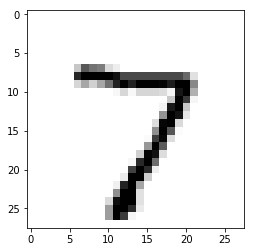

In [14]:
## READ MNIST INPUTS
test_images = mnist.test.images
test_labels = mnist.test.labels
test_images = test_images.reshape([-1, 28, 28, 1])

## Plot the 1st test image and label
plt.imshow(test_images[0,:,:,0], cmap='Greys')
print("\nOne-hot labels for this image:")
print(test_labels[0])

### Check the prediction for the first image

In [15]:
prediction = sess.run(preds, feed_dict={images: test_images[0,:,:,0].reshape(1,28,28,1), labels: test_labels[0]})

print("The prediction of the network is: %d" % np.argmax(prediction))

The prediction of the network is: 7


### Average the accuray for test set

In [16]:
test_acc = accuracy.eval(session=sess, feed_dict={images: test_images, labels: np.argmax(test_labels, axis=1)})
print('Acc: %.3f' % test_acc)

Acc: 0.981


In [17]:
n_parameters = 0
for var in tf.trainable_variables():
    n_parameters += tf.size(var)
n_dnn = sess.run(n_parameters)
print("The number of parameters: %d" % n_dnn)

The number of parameters: 178710


In [18]:
sess.close()
tf.reset_default_graph()